# Introduction

### Challenge: Variability in Experimental Conditions Limits Comparability of Enzyme Activity
As part of my research on plastic biodegradation by enzymes (proteins produced by bacteria and fungi), I compiled a dataset named PANDA (PETase Activity NAtural Dataset), which contains results from ~250 experiments involving ~100 enzymes, each described by 55 features related to enzyme properties and activity.
However, identifying highly active enzymes within the PANDA dataset is non-trivial since these enzymes were tested in highly variable experimental conditions (for example, experiment duration or plastic type), which strongly influence measured activity. As a result, direct comparison of degradation performance across experiments is highly innacurate.

### Hypothesis: Transitive Qualitative Ranking Could Enable Enzyme Comparisons 
I hypothesize that comparative rankings can overcome the comparability issue: if enzyme A performs better than B in one experiment and B better than C in another, it may be inferred that A is also better than C (A > B > C) even when experimental conditions differ. This relies on the assumption that enzyme performance rankings remain transitively consistent across different setups. The extent to which this assumption holds under substantial experimental variability is unknown.

### Approach: Testing Ranking Robustness Using Published Data
To assess the robustness of transitive rankings, I analyzed published experimental data from Erickson et al. (2022), in which 19 enzymes were tested against three PET substrates—amorphous film, amorphous powder, and semi-crystalline powder— measured at eight time points in a time-course experiment.
I treated each combination of **substrate** and **time point** as a distinct “experiment,” yielding **24 experiments** in total. Within each, I ranked the enzymes by performance.
To quantify ranking consistency across experimental conditions, I computed the Kendall Tau coefficient (τ) for every pair of experiments. The τ statistic measures rank correlation: τ = 1 indicates perfect agreement between rankings, while τ = 0 indicates no correlation. This allowed me to evaluate how variation in substrate type and reaction time affects the stability of enzyme performance rankings. 


# Package Imports

In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats
from random import sample, choice
import itertools
from itertools import permutations 
from scipy.stats import kendalltau
from matplotlib.colors import LinearSegmentedColormap

# Dataset Loading and Preprocessing

In [141]:
df = pd.read_excel('data.xlsx', sheet_name='Table D7',
                  index_col=0, header=[0,1,2,3])
df = df.loc[:168, :]
df = df.droplevel('Reaction Condition', axis = 1)
# df.columns = df.columns.reorder_levels(['Substrate','Enzyme ID',  'Measurement'])
df = df.T.reset_index()
df['Enzyme ID'] = df['Enzyme ID'].astype(str)

# Dropping standard deviation data
df = df[df['Measurement'] != 'St. Dev.']
df = df.drop('Measurement', axis = 1)

# Sorting and setting index 
df = df.sort_values(['Substrate', 'Enzyme ID'])
df = df.set_index(['Substrate', 'Enzyme ID']).T
df.index.name = 'Time (h)'
df = df.drop(0)

df

Substrate Amorphous Film                                               \
Enzyme ID            204       211       214       301  307       401   
Time (h)                                                                
3               0.371643  0.257704  0.000000  0.000000  0.0  0.000000   
6               0.586098  0.391381  0.000000  0.341313  0.0  0.000000   
10              0.870278  0.653980  0.109105  0.451240  0.0  0.208471   
24              1.440765  1.374416  0.401684  0.773596  0.0  0.442929   
48              1.606823  1.555787  0.658965  0.972830  0.0  0.515430   
72              1.862721  1.688077  0.687989  1.250781  0.0  0.803809   
96              2.365447  1.887429  1.199047  1.442055  0.0  0.974176   
168             3.573694  2.186014  1.206143  2.205294  0.0  1.436561   

Substrate                                             ... Crystalline Powder  \
Enzyme ID       405       503        504         601  ...                602   
Time (h)                                              ...                      
3          0.000000  0.000000   5.106072   64.307217  ...           2.799975   
6          0.000000  0.000000   9.841066  168.573918  ...           2.869662   
10         0.235656  0.000000  12.197065  223.006282  ...           3.461253   
24         0.692368  0.000000  15.065765  232.304200  ...           3.591910   
48         0.769511  0.000000  16.178179  255.435109  ...           4.855499   
72         1.076393  0.000000  19.601122  246.435990  ...           5.136394   
96         1.807905  0.000000  21.030115  347.661587  ...           6.828906   
168        2.083068  0.673318  29.624807  337.812684  ...          10.285103   

Substrate                                                                \
Enzyme ID      611_pH6    611_pH7.5         701         704         708   
Time (h)                                                                  
3            18.438922    36.280523   19.740344   37.933196    1.883982   
6            53.854052    89.886498   94.811661  104.843714    4.025979   
10          107.990868   131.549711  225.122019  169.125362    7.815832   
24          273.848827   423.432287  348.787681  245.023444   16.897235   
48          516.655087   794.484914  367.794683  221.130322   30.813406   
72          656.075185  1213.281418  404.027706  291.693981   42.089142   
96          882.016990  1436.538841  459.897803  289.880590   54.683588   
168        1085.960000  1659.363427  582.697444  290.555673  135.840987   

Substrate                                                 
Enzyme ID        711         714        717     LCC ICCG  
Time (h)                                                  
3           0.614204   42.207583   4.439795   376.333239  
6           1.559698  112.948071   6.165266   593.779102  
10          2.342591  181.939378   8.470699   700.436837  
24          5.819778  259.225535  12.083167  1024.940394  
48         12.126275  367.542707  25.734061  1179.983584  
72         13.986722  346.399966  19.589193  1318.293125  
96         21.902059  370.057760  28.026341  1537.440954  
168        30.866242  357.254946  39.705385  1339.356552  

[8 rows x 60 columns]

## Extracting Experimental Conditions

In [143]:
enzymes = sorted(set([c[1] for c in df.columns]))
enzymes
timePoints = df.index
timePoints
substrates = sorted(set([c[0] for c in df.columns]))
substrates

['Amorphous Film', 'Amorphous Powder', 'Crystalline Powder']

In [144]:
conditions = []
for s in substrates:
    for t in timePoints:
        conditions.append((s,t))
conditions


[('Amorphous Film', 3),
 ('Amorphous Film', 6),
 ('Amorphous Film', 10),
 ('Amorphous Film', 24),
 ('Amorphous Film', 48),
 ('Amorphous Film', 72),
 ('Amorphous Film', 96),
 ('Amorphous Film', 168),
 ('Amorphous Powder', 3),
 ('Amorphous Powder', 6),
 ('Amorphous Powder', 10),
 ('Amorphous Powder', 24),
 ('Amorphous Powder', 48),
 ('Amorphous Powder', 72),
 ('Amorphous Powder', 96),
 ('Amorphous Powder', 168),
 ('Crystalline Powder', 3),
 ('Crystalline Powder', 6),
 ('Crystalline Powder', 10),
 ('Crystalline Powder', 24),
 ('Crystalline Powder', 48),
 ('Crystalline Powder', 72),
 ('Crystalline Powder', 96),
 ('Crystalline Powder', 168)]

## Data Reformatting

In [146]:
df_piv = df.T.reset_index().pivot(index = 'Enzyme ID', columns='Substrate').T.reset_index().sort_values(['Substrate', 'Time (h)']).set_index(['Substrate', 'Time (h)'])
df_piv

Enzyme ID                          204        211       214       301  \
Substrate          Time (h)                                             
Amorphous Film     3          0.371643   0.257704  0.000000  0.000000   
                   6          0.586098   0.391381  0.000000  0.341313   
                   10         0.870278   0.653980  0.109105  0.451240   
                   24         1.440765   1.374416  0.401684  0.773596   
                   48         1.606823   1.555787  0.658965  0.972830   
                   72         1.862721   1.688077  0.687989  1.250781   
                   96         2.365447   1.887429  1.199047  1.442055   
                   168        3.573694   2.186014  1.206143  2.205294   
Amorphous Powder   3          2.981719   0.436258  0.000000  0.170028   
                   6          4.076966   1.085087  0.000000  0.924932   
                   10         5.131780   1.785928  0.000000  0.984257   
                   24         7.296618   3.892802  0.000000  2.348347   
                   48         7.306189   5.464619  0.000000  2.600999   
                   72        12.005844   7.147787  0.000000  2.675071   
                   96        17.362021   6.389604  0.000000  3.931209   
                   168       26.347743  11.205850  0.000000  5.068310   
Crystalline Powder 3          4.168628   0.701473  0.740013  0.000000   
                   6          4.718555   1.118069  0.675200  0.262367   
                   10         5.139580   1.604376  0.815748  0.302277   
                   24         9.269382   1.976898  1.024859  0.528636   
                   48         6.043174   2.779557  0.887833  0.844995   
                   72         7.274412   3.080660  0.939447  0.922088   
                   96         8.653743   3.246356  1.052933  1.222750   
                   168       14.303171   3.320895  1.883758  1.929875   

Enzyme ID                         307         401       405         503  \
Substrate          Time (h)                                               
Amorphous Film     3         0.000000    0.000000  0.000000    0.000000   
                   6         0.000000    0.000000  0.000000    0.000000   
                   10        0.000000    0.208471  0.235656    0.000000   
                   24        0.000000    0.442929  0.692368    0.000000   
                   48        0.000000    0.515430  0.769511    0.000000   
                   72        0.000000    0.803809  1.076393    0.000000   
                   96        0.000000    0.974176  1.807905    0.000000   
                   168       0.000000    1.436561  2.083068    0.673318   
Amorphous Powder   3         0.000000    4.814280  0.136099    5.363255   
                   6         0.000000   14.886279  0.736322   10.304243   
                   10        0.000000   47.626370  0.872445   15.498161   
                   24        0.000000  107.832294  3.002539   49.218454   
                   48        0.269178  118.987877  3.738721  109.494299   
                   72        0.422209  225.518496  4.402003  136.969125   
                   96        0.406942  258.445220  5.528806  177.453687   
                   168       0.548527  338.093588  6.712702  293.636881   
Crystalline Powder 3         0.000000    9.969452  0.000000    3.011202   
                   6         0.000000   25.172471  0.057881    7.206025   
                   10        0.000000   39.910388  0.168210   11.555937   
                   24        0.000000   75.721203  0.863808   41.038441   
                   48        0.000000   95.899313  1.149028   65.451661   
                   72        0.000000   97.890678  1.586675  123.171290   
                   96        0.000000  167.292613  1.674238  187.148468   
                   168       0.000000  179.107015  2.529927  383.182071   

Enzyme ID                            504         601        602      611_pH6  \
Substrate          Time (h)                                           

# Testing the Robustness of Transitive Qualitative Ranking

## Preparing the matrix to hold statistical analysis results

In [149]:
# create matrix with all conditions
index = pd.MultiIndex.from_tuples(conditions, names=["Substrate", "Time (h)"])
kendCorMat = pd.DataFrame(index = index, columns = index) 
kendPvalMat = kendCorMat.copy()
kendCorMat

Substrate                   Amorphous Film                                     \
Time (h)                               3    6    10   24   48   72   96   168   
Substrate          Time (h)                                                     
Amorphous Film     3                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   6                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   10                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   24                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   48                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   72                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   96                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   168                 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Amorphous Powder   3                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   6                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   10                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   24                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   48                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   72                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   96                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   168                 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Crystalline Powder 3                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   6                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   10                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   24                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   48                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   72                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   96                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   168                 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

Substrate                   Amorphous Powder       ...            \
Time (h)                                 3    6    ...  96   168   
Substrate          Time (h)                        ...             
Amorphous Film     3                     NaN  NaN  ...  NaN  NaN   
                   6                     NaN  NaN  ...  NaN  NaN   
                   10                    NaN  NaN  ...  NaN  NaN   
                   24                    NaN  NaN  ...  NaN  NaN   
                   48                    NaN  NaN  ...  NaN  NaN   
                   72                    NaN  NaN  ...  NaN  NaN   
                   96                    NaN  NaN  ...  NaN  NaN   
                   168                   NaN  NaN  ...  NaN  NaN   
Amorphous Powder   3                     NaN  NaN  ...  NaN  NaN   
                   6                     NaN  NaN  ...  NaN  NaN   
                   10                    NaN  NaN  ...  NaN  NaN   
                   24                    NaN  NaN  ...  NaN  NaN   
                   48                    NaN  NaN  ...  NaN  NaN   
                   72                    NaN  NaN  ...  NaN  NaN   
                   96                    NaN  NaN  ...  NaN  NaN   
                   168                   NaN  NaN  ...  NaN  NaN   
Crystalline Powder 3                     NaN  NaN  ...  NaN  NaN   
                   6                     NaN  NaN  ...  NaN  NaN   
                   10                    NaN  NaN  ...  NaN  NaN   
                   24                    NaN  NaN  ...  NaN  NaN   
                   48                    NaN  NaN  ...  NaN  NaN   
                   72                    NaN  NaN  ...  NaN  NaN   
                   96                    NaN  NaN  ...  NaN  NaN   
                   168                   NaN

## Pairwise Calculation of Rank Correlation Between the 24 Experimental Setups 

I computed the Kendall Tau coefficient between each pair of experiments. The resulting value, ranging from 0 to 1, describes how well the enzyme rankings agree between two experiments with different plastic types (`Substrate`) and/or experiment durations (`Time (h)`)


In [151]:
for s1,t1 in conditions:
    x = df_piv.loc[(s1,t1)] # returns a Series with experimental results in one combination of Time and Substrate
    for s2,t2 in conditions:
        y = df_piv.loc[(s2,t2)]  # returns a Series with experimental results in a second combination of Time and Substrate
        res = kendalltau(x, y) # calculates rank correlation between the ranking of the enzymes in the two experiments
        kendCorMat.loc[(s1,t1), (s2,t2)] = res.statistic # insert the results into the statistical results matrix 
kendCorMat = kendCorMat.astype(float) # converting to matrix to Float


# Visualization of Analysis Results

The results are displayed as a heatmap. Each labeled square contains the rank correlations of one substrate combination.

For example, the square labeled `B` contains the correlations for all time points between experiments with `Amorphous Film` and experiments with `Amorphous Powder`. 

The fact that square `E` holds higher values than square `B` means that there is better correlation between experiments where the substrate is powder (whether amorphous or crystalline) than between experiments where the substrate is amorphous but differs in form (i.e., film vs. powder). 
This result was unexpected.
More importantly, the lowest observed correlation (τ = 0.47) corresponds to a still reasonable likelihood (73.5%, given by the formula p=(τ+1)/2) of consistent rankings across experiments despite significant differences in substrate and reaction time. 

In [153]:
pastel_cmap = LinearSegmentedColormap.from_list("pastel", ['#D64161FF',"#00539CFF", ])

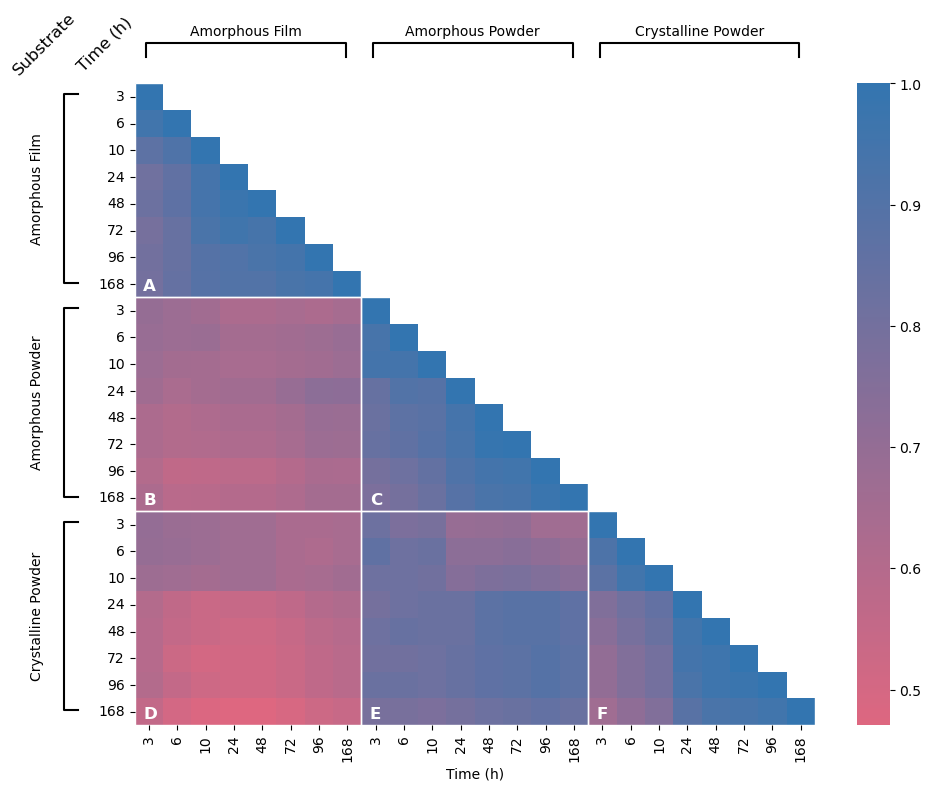

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

fig, ax = plt.subplots(figsize=(10, 8), 
                       # dpi=300
                      )

labels = [f"{sub}-{t}" for sub in substrates for t in timePoints]

kendCorMat_lTri = pd.DataFrame(np.tril(kendCorMat), index = kendCorMat.index, columns = kendCorMat.columns).replace(0, np.nan)
sns.heatmap(kendCorMat_lTri, ax=ax, cmap=pastel_cmap, annot=False)

# Make tick labels just the numbers
ax.set_xticklabels(list(timePoints) * 3, rotation=0)
ax.set_yticklabels(list(timePoints) * 3, rotation=0)

# Bracket drawing function
def add_bracket(ax, start, end, y, label, axis='x'):
    """Draws a bracket and label along the axis."""
    if axis == 'x':
        ax.plot([start, start, end, end], [y, y-0.5, y-0.5, y], color='black', clip_on=False, lw=1.5)
        ax.text((start + end) / 2, y - 1.2, label, ha='center', va='top', fontsize=10)
    elif axis == 'y':
        ax.plot([y, y-0.5, y-0.5, y], [start, start, end, end], color='black', clip_on=False, lw=1.5)
        ax.text(y - 1.2, (start + end) / 2, label, ha='right', va='center', fontsize=10, rotation=90)

# Remove axis labels
ax.set_xlabel("Time (h)")
ax.set_ylabel("")

group_size = len(timePoints)
Ps = [0.05, 1.05, 2.05]

# Add x-axis brackets
for i, lab in zip(Ps, substrates):
    start = i * group_size
    end = start + group_size - 0.95
    add_bracket(ax, start, end, -1, lab, axis='x')

# Add y-axis brackets
for i, lab in zip(Ps, substrates):
    start = i * group_size
    end = start + group_size -0.95
    add_bracket(ax, start, end, -2, lab, axis='y')

# Draw white thin borders & add bold labels A-H only for lower triangle
letters = list("ABCDEF")
label_idx = 0
for i in range(0, kendCorMat_lTri.shape[0], group_size):
    for j in range(0, kendCorMat_lTri.shape[1], group_size):
        if i >= j:  # only lower triangle blocks
            # White border
            rect = plt.Rectangle((j, i), group_size, group_size,
                                 fill=False, edgecolor='white', linewidth=1.0)
            ax.add_patch(rect)
            
            # Bold label in top-left of the square
            ax.text(j + 0.3, i + group_size - 0.7,
                    letters[label_idx], ha='left', va='top',
                    fontsize=12, fontweight='bold', color='white')
            
            label_idx += 1

# Add 'Time' and 'Substrate' axis labels
ax.text(-2, -1.5, 'Substrate', ha='right', va='center', fontsize=12, rotation=45)
ax.text(0, -1.5, 'Time (h)', ha='right', va='center', fontsize=12, rotation=45)

# Reduce alpha for the heatmap itself
alpha = 0.8

for quad in ax.collections:
    quad.set_alpha(alpha)  # Adjust this value as needed for transparency

# Adjust the colorbar alpha
colorbar = ax.collections[0].colorbar
colorbar.ax.patch.set_alpha(alpha)  # Match this alpha with the heatmap
colorbar.update_normal(ax.collections[0])  # Sync the colorbar with the heatmap
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')


plt.tight_layout()
plt.show()


## Summary Statistics
This section shows the minimal and median tau values and the corresponding probabilities of consistent rankings across the whole dataset, and between each pair of substrates.

The median probabilities for consistent rankings among experiments using different substrates range from 79.5% to 91%, validating my proposal to use qualitative rankings and transitivity to rank plastic degrading enzymes. These results confirm that if enzyme A outperforms B in one experiment and B outperforms C in another, there is at least a 73.5% likelihood that A will outperform C, even under different experimental conditions.

In [156]:
# excluding the main diagonal where all correlations equal 1
no_diag = kendCorMat.astype(float)
np.fill_diagonal(no_diag.values, np.nan)

In [157]:
def calc_prob(tau):
    """
    A function to calculate probability for consistent rankings from tau value, given by ((tau + 1) / 2) * 100
    """
    return round(((tau + 1) / 2) * 100, 1)

def calc_med(s1, s2):
    """
    A function to calculate the median tau value and likelihood for consistent rankings 
    of two different substrates
    """
    tau = round(kendCorMat.loc[s1, s2].stack().median(), 2)
    prob = calc_prob(tau)
    print()
    print (f'Median τ-value for experiments using {s1} vs. experiments using {s2} is {tau}.', 
           f'This corresponds to a {prob}% likelihood that rankings between the two substrates would be consistent.', sep = '\n')
    

In [158]:
# calculating minimal tau value for the whole matrix
min_tau = round(no_diag.min().min(), 2)
print(f'Minimal τ-value of the whole correlation matrix: {min_tau}',
     f'This corresponds to a {calc_prob(min_tau)}% likelihood that rankings between the two least-correlated experiments would be consistent.',
    sep = '\n')
print()

# calculating the median tau value for the whole matrix
med_tau = round(no_diag.median().median(),2)
print(f'Median τ-value of the whole correlation matrix: {med_tau}', 
      f'This corresponds to a {calc_prob(med_tau)}% likelihood that rankings between any two experiments would be consistent.', 
     sep = '\n')
print()


# calculating the median tau for each substrate pair 

calc_med('Amorphous Film', 'Amorphous Powder')
print('(Square B)')

calc_med('Amorphous Film', 'Crystalline Powder')
print('(Square D)')

calc_med('Amorphous Powder', 'Crystalline Powder')
print('(Square E)')

Minimal τ-value of the whole correlation matrix: 0.47
This corresponds to a 73.5% likelihood that rankings between the two least-correlated experiments would be consistent.

Median τ-value of the whole correlation matrix: 0.78
This corresponds to a 89.0% likelihood that rankings between any two experiments would be consistent.


Median τ-value for experiments using Amorphous Film vs. experiments using Amorphous Powder is 0.64.
This corresponds to a 82.0% likelihood that rankings between the two substrates would be consistent.
(Square B)

Median τ-value for experiments using Amorphous Film vs. experiments using Crystalline Powder is 0.59.
This corresponds to a 79.5% likelihood that rankings between the two substrates would be consistent.
(Square D)

Median τ-value for experiments using Amorphous Powder vs. experiments using Crystalline Powder is 0.82.
This corresponds to a 91.0% likelihood that rankings between the two substrates would be consistent.
(Square E)


# Conclusions
This short analysis was intended to create a data-informed solution to the problem of comparing enzyme activity across experiments with varying experimental conditions. 
I reformatted a published experimental dataset to simulate 24 different experiments that differ in only two experimental conditions: experiment duration and plastic type. 
I then ranked the enzymes in each "experiment" and computed the rank correlation between each pair of experiments.
I found that:
- Even the minimal correlation, observed in experiments where both substrate type and duration differed greatly (square `D`, lower part), still corresponds to a 73.5% probability of ranking agreement.
- Interestingly and against my expectations as a researcher in the plastic biodegradation field, the analysis suggests that experiments where plastic form is the same (i.e., powder) regardless of the crystallinity level, correlate better than experiments using substrates with the same crystallinity but of a different form.
- Following this analysis, I analyzed the PANDA dataset using the transitivity of qualitative rankings, and identified 20 highly active enzymes in the PANDA dataset. These results were published in the Q1 journal "Protein Science" under the title "The diversity of PET degrading enzymes: a systematic review of sequence, structure, and function".

# Discalimers

- In this analysis, I treated different time points from a single time-course experiment as independent experiments. This limitation mainly affects comparisons between different time points of the same substrate type (squares `A`, `C`, and `F`). However, my main conclusions were drawn from comparisons where both substrate type and experiment duration differed.

- In the PANDA dataset, more than two experimental conditions may vary (e.g., measurement tools, enzyme concentration, and others), which would likely reduce the actual likelihood of ranking agreement between experiments.